# Prepare Variable Data Processing Checklist

## Compute for: (Common Climatology - 1980-2010 (or 1990-2020?))
- [ ] Short-term [1980-2023]
- [ ] Long-term [1901-2023]

## Combine datasets
- [ ] Merge all results into one xarrays
    - [ ] Short-term
    - [ ] Long-term

# Load Packages + Filepath

In [5]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import xesmf as xe
import xcdat as xc

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import zscore
from scipy.stats import t
from scipy.signal import butter, filtfilt, detrend, welch

In [6]:
input_filepath1 = "../../data/"
input_filepath2 = "../../data/created/"

In [7]:
%load_ext autoreload
%autoreload 2

# Load Local Utils
import plotting_utils
import index_utils

In [8]:
# # Copy Time Length and Style from ENSO.
# #enso_processed['seasonal'].time.to_netcdf("data/TIME.nc") 

time_seasonal = xr.open_dataset("data/TIME.nc")#.rename({'latitude': 'lat', 'longitude': 'lon'}).bounds.add_missing_bounds()
time_seasonal

<xarray.Dataset> Size: 8kB
Dimensions:                        (time: 484)
Coordinates:
  * time                           (time) datetime64[ns] 4kB 1902-12-01 ... 2...
Data variables:
    __xarray_dataarray_variable__  (time) datetime64[ns] 4kB ...
Attributes:
    __xarray_dataarray_name__:  time

In [39]:
time_seasonal_st = time_seasonal.sel(time=slice('1979-12-01', '2023-12-31'))
time_seasonal_st 

<xarray.Dataset> Size: 3kB
Dimensions:                        (time: 176)
Coordinates:
  * time                           (time) datetime64[ns] 1kB 1979-12-01 ... 2...
Data variables:
    __xarray_dataarray_variable__  (time) datetime64[ns] 1kB ...
Attributes:
    __xarray_dataarray_name__:  time

# LONG TERM VARS
SST [OCEAN], PDSI[LAND], PPT [LAND]

# Load SST

In [22]:
# Load and clean SST dataset
sst = xc.open_dataset(input_filepath1 + "HADI_SST_1900_2023.nc").rename({'latitude': 'lat', 'longitude': 'lon'}).bounds.add_missing_bounds()
sst = sst.sel(time=slice('1900-12-01', '2024-01-31'))#, lat = slice(70, -70))
sst = sst.where(sst != -1000, np.nan)  # Mask invalid values

## Long Term

In [ ]:
sst_anomalies_no_ref = sst.temporal.departures(
    "sst",
    freq="season",
    weighted=True,
    season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
    #reference_period = ('1981-01-01', '2010-12-31'),

)

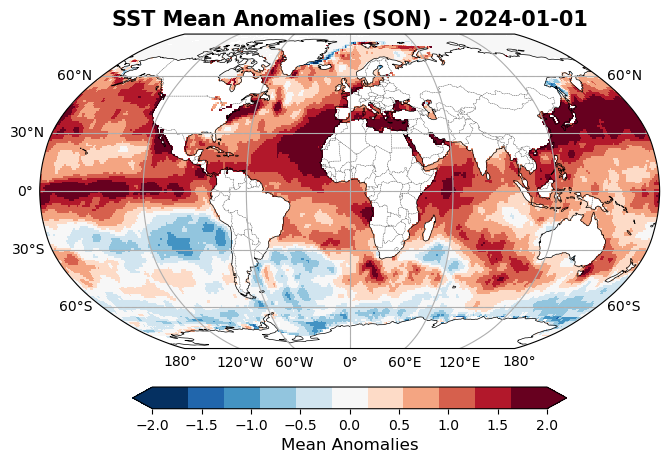

In [8]:
plotting_utils.single_plot(
    sst_anomalies_no_ref.sst.isel(time=-1),
    f"SST Mean Anomalies (SON) - {str(sst_anomalies_no_ref.time[-1].values)[:10]}",
    "RdBu_r",
    11,
    -2,
    2,
    "Mean Anomalies"
)

In [35]:
sst_mean_anomalies = sst_anomalies_no_ref.sel(time=slice('1902-12-01', '2023-12-31'))
sst_mean_anomalies = sst_mean_anomalies.rename({"sst": "sst_anom"})
sst_mean_anomalies['time'] = time_seasonal.time
sst_mean_anomalies

<xarray.Dataset> Size: 251MB
Dimensions:         (lat: 180, lon: 360, bnds: 2, time: 484)
Coordinates:
  * lat             (lat) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon             (lon) float32 1kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time            (time) datetime64[ns] 4kB 1902-12-01 ... 2023-09-01
Dimensions without coordinates: bnds
Data variables:
    longitude_bnds  (lon, bnds) float32 3kB -180.0 -179.0 -179.0 ... 179.0 180.0
    latitude_bnds   (lat, bnds) float32 1kB 90.0 89.0 89.0 ... -89.0 -89.0 -90.0
    sst_anom        (time, lat, lon) float64 251MB nan nan nan ... nan nan nan
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    4/11/2024 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

In [45]:
sst_mean_anomalies.to_netcdf('created/SST_Anom_1903_2023.nc')

## Short Term [1980-2023]

In [45]:
sst_st = sst.sel(time=slice('1979-12-01', '2023-12-31'))

sst_anomalies_st = sst_st.temporal.departures(
    "sst",
    freq="season",
    weighted=True,
    season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
    #reference_period = ('1981-01-01', '2010-12-31'),

)

sst_anomalies_st['time'] = time_seasonal_st.time
sst_anomalies_st

<xarray.Dataset> Size: 91MB
Dimensions:         (lat: 180, lon: 360, bnds: 2, time: 176)
Coordinates:
  * lat             (lat) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon             (lon) float32 1kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time            (time) datetime64[ns] 1kB 1979-12-01 ... 2023-09-01
Dimensions without coordinates: bnds
Data variables:
    longitude_bnds  (lon, bnds) float32 3kB -180.0 -179.0 -179.0 ... 179.0 180.0
    latitude_bnds   (lat, bnds) float32 1kB 90.0 89.0 89.0 ... -89.0 -89.0 -90.0
    sst             (time, lat, lon) float64 91MB nan nan nan ... nan nan nan
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    4/11/2024 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

# Load TMP

In [47]:
# Load and clean SST dataset
tmp = xc.open_dataset(input_filepath1 + "TMP_CRU_1901_2024.nc").bounds.add_missing_bounds()
tmp = tmp.sel(time=slice('1900-12-01', '2024-01-31'))#, lat = slice(70, -70))
tmp

<xarray.Dataset> Size: 8GB
Dimensions:    (lon: 720, lat: 360, time: 1477, bnds: 2)
Coordinates:
  * lon        (lon) float32 3kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat        (lat) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time       (time) object 12kB 1901-01-16 00:00:00 ... 2024-01-16 00:00:00
Dimensions without coordinates: bnds
Data variables:
    tmp        (time, lat, lon) float32 2GB ...
    stn        (time, lat, lon) float64 3GB ...
    mae        (time, lat, lon) float32 2GB ...
    maea       (time, lat, lon) float32 2GB ...
    lon_bnds   (lon, bnds) float32 6kB -180.0 -179.5 -179.5 ... 179.5 180.0
    lat_bnds   (lat, bnds) float32 3kB -90.0 -89.5 -89.5 ... 89.5 89.5 90.0
    time_bnds  (time, bnds) object 24kB 1901-01-01 00:00:00 ... 2024-02-01 00...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.09 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2503051245. Data generated from:tmp.2503051121.dtb
    history:      Wed  5 Mar 13:28:04 GMT 2025 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

In [30]:
tmp_anomalies_no_ref = tmp.temporal.departures(
    "tmp",
    freq="season",
    weighted=True,
    season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
    #reference_period = ('1981-01-01', '2010-12-31'),

)

tmp_anomalies_no_ref

<xarray.Dataset> Size: 1GB
Dimensions:   (lon: 720, lat: 360, bnds: 2, time: 492)
Coordinates:
  * lon       (lon) float32 3kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat       (lat) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time      (time) object 4kB 1901-04-01 00:00:00 ... 2024-01-01 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lon_bnds  (lon, bnds) float32 6kB -180.0 -179.5 -179.5 ... 179.5 179.5 180.0
    lat_bnds  (lat, bnds) float32 3kB -90.0 -89.5 -89.5 -89.0 ... 89.5 89.5 90.0
    tmp       (time, lat, lon) float64 1GB nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.09 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2503051245. Data generated from:tmp.2503051121.dtb
    history:      Wed  5 Mar 13:28:04 GMT 2025 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

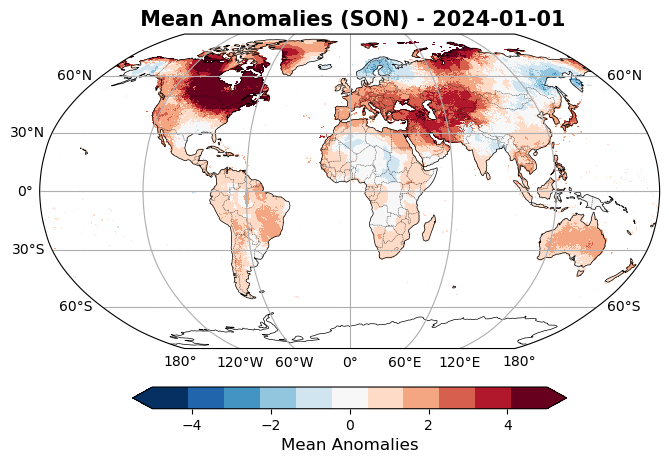

In [34]:
plotting_utils.single_plot(
    tmp_anomalies_no_ref.tmp.isel(time=-1),
    f" Mean Anomalies (SON) - {str(tmp_anomalies_no_ref.time[-1].values)[:10]}",
    "RdBu_r",
    11,
    -5,
    5,
    "Mean Anomalies"
)

In [36]:
tmp_mean_anomalies = tmp_anomalies_no_ref.sel(time=slice('1902-12-01', '2023-12-31'))
tmp_mean_anomalies = tmp_mean_anomalies.rename({"tmp": "tmp_anom"})
tmp_mean_anomalies['time'] = time_seasonal.time
tmp_mean_anomalies

<xarray.Dataset> Size: 1GB
Dimensions:   (lon: 720, lat: 360, bnds: 2, time: 484)
Coordinates:
  * lon       (lon) float32 3kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat       (lat) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time      (time) datetime64[ns] 4kB 1902-12-01 1903-03-01 ... 2023-09-01
Dimensions without coordinates: bnds
Data variables:
    lon_bnds  (lon, bnds) float32 6kB -180.0 -179.5 -179.5 ... 179.5 179.5 180.0
    lat_bnds  (lat, bnds) float32 3kB -90.0 -89.5 -89.5 -89.0 ... 89.5 89.5 90.0
    tmp_anom  (time, lat, lon) float64 1GB nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.09 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2503051245. Data generated from:tmp.2503051121.dtb
    history:      Wed  5 Mar 13:28:04 GMT 2025 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

In [46]:
tmp_mean_anomalies.to_netcdf('created/TMP_Anom_1903_2023.nc')

## Short Term (1980-2023)

In [48]:
tmp_st = tmp.sel(time=slice('1979-12-01', '2023-12-31'))

tmp_anomalies_st = tmp_st.temporal.departures(
    "tmp",
    freq="season",
    weighted=True,
    season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
    #reference_period = ('1981-01-01', '2010-12-31'),

)

tmp_anomalies_st['time'] = time_seasonal_st.time
tmp_anomalies_st

<xarray.Dataset> Size: 365MB
Dimensions:   (lon: 720, lat: 360, bnds: 2, time: 176)
Coordinates:
  * lon       (lon) float32 3kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat       (lat) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time      (time) datetime64[ns] 1kB 1979-12-01 1980-03-01 ... 2023-09-01
Dimensions without coordinates: bnds
Data variables:
    lon_bnds  (lon, bnds) float32 6kB -180.0 -179.5 -179.5 ... 179.5 179.5 180.0
    lat_bnds  (lat, bnds) float32 3kB -90.0 -89.5 -89.5 -89.0 ... 89.5 89.5 90.0
    tmp       (time, lat, lon) float64 365MB nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.09 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2503051245. Data generated from:tmp.2503051121.dtb
    history:      Wed  5 Mar 13:28:04 GMT 2025 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

# Load PDSI

In [51]:
masked = xr.open_dataset(input_filepath2 + 'Aridity_Binary_Mask.nc').drop_vars('pdsi_land_area')
pdsi = xr.open_dataset(input_filepath1 + "PDSI_CRU_1901_2023.nc")#.bounds.add_missing_bounds()
pdsi  = pdsi.rename({'latitude': 'lat', 'longitude': 'lon'}) 
pdsi = pdsi.sel(time =slice('1902-12-01', '2023-11-30'), lat = slice(70, -70))
pdsi['pdsi_masked'] = pdsi['scpdsi'] * masked['mask']
pdsi_seasonal = pdsi.resample(time='QS-DEC').mean(dim='time',skipna=False)
pdsi_seasonal
#pdsi_seasonal = pdsi_seasonal.assign_coords(season=pdsi_seasonal['time'].dt.season)

<xarray.Dataset> Size: 2GB
Dimensions:      (time: 484, lat: 280, lon: 720)
Coordinates:
  * lon          (lon) float64 6kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat          (lat) float64 2kB 69.75 69.25 68.75 ... -68.75 -69.25 -69.75
  * time         (time) datetime64[ns] 4kB 1902-12-01 1903-03-01 ... 2023-09-01
Data variables:
    scpdsi       (time, lat, lon) float64 781MB nan nan nan nan ... nan nan nan
    pdsi_masked  (time, lat, lon) float64 781MB nan nan nan nan ... nan nan nan
Attributes:
    creation_date:                             24-Feb-2024 19:00:56
    Institution:                               Climatic Research Unit, Univer...
    creator:                                   Prof. Jonathan Barichivich (jo...
    Original reference for computation setup:  van der Schrier G, Barichivich...
    Updated reference:                         J. Barichivich, Osborn TJ, Har...

In [ ]:
#pdsi_seasonal.to_netcdf('created/PDSI_Anom_1903_2023.nc')

## Short Term

In [52]:
pdsi_st = pdsi.sel(time=slice('1979-12-01', '2023-12-31')).resample(time='QS-DEC').mean(dim='time',skipna=False)
pdsi_st

<xarray.Dataset> Size: 568MB
Dimensions:      (time: 176, lat: 280, lon: 720)
Coordinates:
  * lon          (lon) float64 6kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat          (lat) float64 2kB 69.75 69.25 68.75 ... -68.75 -69.25 -69.75
  * time         (time) datetime64[ns] 1kB 1979-12-01 1980-03-01 ... 2023-09-01
Data variables:
    scpdsi       (time, lat, lon) float64 284MB nan nan nan nan ... nan nan nan
    pdsi_masked  (time, lat, lon) float64 284MB nan nan nan nan ... nan nan nan
Attributes:
    creation_date:                             24-Feb-2024 19:00:56
    Institution:                               Climatic Research Unit, Univer...
    creator:                                   Prof. Jonathan Barichivich (jo...
    Original reference for computation setup:  van der Schrier G, Barichivich...
    Updated reference:                         J. Barichivich, Osborn TJ, Har...

# Load PPT

In [9]:
# --- Load and clean PPT dataset ---
ppt = xc.open_dataset(input_filepath1 + "PPT_CRU_1901_2024.nc").bounds.add_missing_bounds()#.sel(time=slice('1902-12-01', '2023-11-30'), lat=slice(70, -70))
ppt = ppt.reindex(lat=list(reversed(ppt.lat)))
ppt = ppt.sel(time=slice('1902-12-01', '2023-11-30'), lat=slice(70, -70))

In [10]:
ppt_climatology = ppt.temporal.climatology(
    "pre",
    freq="season",
    weighted=True,
    season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
).groupby('time.season')

ppt_anomalies = ppt.temporal.departures(
    "pre",
    freq="season",
    weighted=True,
    season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
).groupby('time.season')

ppt_DJF_percent_anom = (ppt_anomalies['DJF'].pre / ppt_climatology['DJF'].pre.isel(time = 0)) * 100


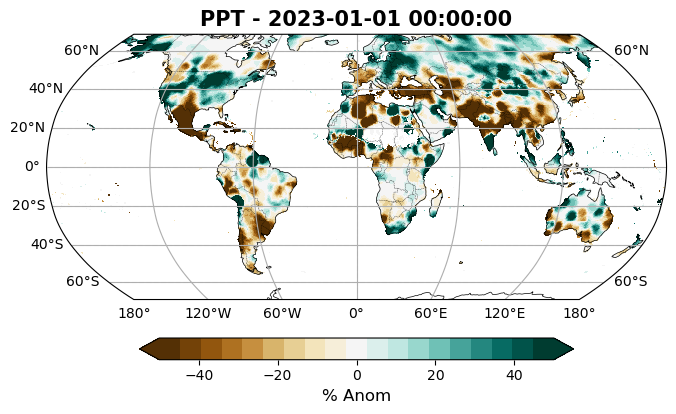

In [11]:
plotting_utils.single_plot(ppt_DJF_percent_anom.isel(time=-1), f"PPT - {ppt_DJF_percent_anom.isel(time=-1).time.values}" ,
               "BrBG", 19, -50, 50, '% Anom')

In [12]:
ppt_DJF_percent_anom = (ppt_anomalies['DJF'].pre / ppt_climatology['DJF'].pre.isel(time = 0)) * 100
ppt_JJA_percent_anom = (ppt_anomalies['JJA'].pre / ppt_climatology['JJA'].pre.isel(time = 0)) * 100
ppt_MAM_percent_anom = (ppt_anomalies['MAM'].pre / ppt_climatology['MAM'].pre.isel(time = 0)) * 100
ppt_SON_percent_anom = (ppt_anomalies['SON'].pre / ppt_climatology['SON'].pre.isel(time = 0)) * 100

In [17]:
ppt_percent_anoms = {
    'DJF': ppt_DJF_percent_anom,
    'MAM': ppt_MAM_percent_anom,
    'JJA': ppt_JJA_percent_anom,
    'SON': ppt_SON_percent_anom
}

combined_ppt = xr.concat(
    [ppt_percent_anoms[s] for s in ['DJF', 'MAM', 'JJA', 'SON']],
    dim='time'
)

combined_ppt

<xarray.DataArray 'pre' (time: 484, lat: 280, lon: 720)> Size: 781MB
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,  21.24759739,
          21.41904432,          nan],
        [ 21.92337449,  22.00163862,  21.82805279, ...,  20.77946504,
          21.0706389 ,  21.49339316],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,  20.90026994,
          21.04596021,          nan],
        [ 21.53021924,  21.5905027 ,  21.4373255 , ...,  20.50747924,
          20.77632087,  21.15134318],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,  18.20279573,
          15.61583824,          nan],
        [  7.35896355,   5.18270609,   3.35353905, ...,  14.3421005 ,
          11.83474928,   9.35064086],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * lon      (lon) float32 3kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 1kB 69.75 69.25 68.75 68.25 ... -68.75 -69.25 -69.75
  * time     (time) object 4kB 1903-01-01 00:00:00 ... 2023-10-01 00:00:00

In [18]:
combined_ppt['time'] = time_seasonal.time
combined_ppt

<xarray.DataArray 'pre' (time: 484, lat: 280, lon: 720)> Size: 781MB
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,  21.24759739,
          21.41904432,          nan],
        [ 21.92337449,  22.00163862,  21.82805279, ...,  20.77946504,
          21.0706389 ,  21.49339316],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,  20.90026994,
          21.04596021,          nan],
        [ 21.53021924,  21.5905027 ,  21.4373255 , ...,  20.50747924,
          20.77632087,  21.15134318],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,  18.20279573,
          15.61583824,          nan],
        [  7.35896355,   5.18270609,   3.35353905, ...,  14.3421005 ,
          11.83474928,   9.35064086],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * lon      (lon) float32 3kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 1kB 69.75 69.25 68.75 68.25 ... -68.75 -69.25 -69.75
  * time     (time) datetime64[ns] 4kB 1902-12-01 1903-03-01 ... 2023-09-01

In [20]:
combined_ppt.to_netcdf('created/PPT_Anom_1903_2023.nc')

#  Save Long Term Variables

In [43]:
vars_seasonal_1903_2023 = xr.Dataset({
    'PDSI_Anom': pdsi_seasonal['pdsi_masked'],
    'SST_Anom': sst_mean_anomalies['sst_anom'],
    'TMP_Anom': tmp_mean_anomalies['tmp_anom'],
    'PPT_Pct_Anom': combined_ppt
})

# Optional: Add metadata
vars_seasonal_1903_2023.attrs["description"] = "Anomalies of PDSI, SST, TMP, PPT (1903-2023 Climatology)"
vars_seasonal_1903_2023

<xarray.Dataset> Size: 16GB
Dimensions:       (lon: 1080, lat: 540, time: 484, season: 4)
Coordinates:
  * lon           (lon) float64 9kB -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat           (lat) float64 4kB -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
  * time          (time) datetime64[ns] 4kB 1902-12-01 1903-03-01 ... 2023-09-01
Dimensions without coordinates: season
Data variables:
    PDSI_Anom     (time, lat, lon) float64 2GB nan nan nan nan ... nan nan nan
    SST_Anom      (time, lat, lon) float64 2GB nan nan nan nan ... nan nan nan
    TMP_Anom      (time, lat, lon) float64 2GB nan nan nan nan ... nan nan nan
    PPT_Pct_Anom  (season, time, lat, lon) float64 9GB nan nan nan ... nan nan
Attributes:
    description:  Anomalies of PDSI, SST, TMP, PPT (1903-2023 Climatology)

In [44]:
vars_seasonal_1903_2023.to_netcdf("Variables_1903_2023.nc")

# Load SLP

Allan, R. J. and Ansell, T. J. (2006) 'A new globally complete monthly historical mean sea level pressure data set (HadSLP2): 1850-2004', Journal of Climate, (accepted)

The source should also be quoted in the acknowledgements section as www.metoffice.gov.uk/hadobs.

In [ ]:
slp = xr.open_dataset("data/slp.mon.mean.nc")#.rename({'latitude': 'lat', 'longitude': 'lon'})#.bounds.add_missing_bounds()
slp = slp.assign_coords(lon=((slp.lon +180) % 360) - 180).sortby('lon')

da = slp.slp.isel(time=-1)

# Plot filled background
fig, ax = plt.subplots(figsize=(10,6))
da.plot(ax=ax, cmap="coolwarm", add_colorbar=True)

# Add contour lines
cs = ax.contour(
    da.lon, da.lat, da,
    levels=15, colors="black", linewidths=0.5
)
ax.clabel(cs, inline=True, fontsize=8, fmt="%.0f")

ax.set_title(f"Sea Level Pressure Contours {str(da.time.values)[:10]}")
plt.show()


In [ ]:
#Create Climatology
slp_gb = slp.groupby('time.month')
slp_anom = slp_gb - slp_gb.mean(dim='time') # Remove mean and create anomaly data
slp_anom

# Bottom